# Made by XDBoobs team ;)

In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV,  StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, auc

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Importing the dataset:

In [2]:
data = pd.read_csv("C:/int20h-ds-test-dataset.csv")

### Inspecting the data:

In [3]:
data.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23357 entries, 0 to 23356
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   userid              23357 non-null  object
 1   user_state          23286 non-null  object
 2   event_name          23357 non-null  object
 3   event_attributes    23357 non-null  object
 4   event_created_date  23357 non-null  object
 5   event_platform      23357 non-null  object
 6   device_manufacture  15847 non-null  object
 7   device_model        15847 non-null  object
dtypes: object(8)
memory usage: 1.4+ MB


### Oops... Some columns have missing values

In [5]:
columns_with_missing_data = data.columns[data.isnull().any()]

print("Columns with missing data: ")
for i, col in enumerate(columns_with_missing_data):
    print(i+1, col)

Columns with missing data: 
1 user_state
2 device_manufacture
3 device_model


#### Percentage of missing data

In [6]:
print("Percentage of missing data: ")
data.isnull().sum() / data.shape[0] * 100

Percentage of missing data: 


userid                 0.000000
user_state             0.303977
event_name             0.000000
event_attributes       0.000000
event_created_date     0.000000
event_platform         0.000000
device_manufacture    32.153102
device_model          32.153102
dtype: float64

In [7]:
data[data['device_manufacture'].isnull()].head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
23,c664cc762bdcb88230b4b4f07e3b7d2e,CA,Transaction Refund,"{""Id"":""708ee8f2012042b121be7dcdd6df256a"",""Amou...",2022-01-16 21:41:05,outofband,NaN,NaN
34,017f4557810b3ba165d2959c17b916b6,TX,Subscription Premium,"{""Start Date"":""2022-01-16"",""Renewal Date"":""202...",2022-01-17 00:04:58,outofband,NaN,NaN
72,0d51394c39dbf15021ccd09155ee6257,FL,Order,"{""Premium Membership"":""True""}",2022-01-15 09:23:48,outofband,NaN,NaN
73,0d51394c39dbf15021ccd09155ee6257,FL,Order,"{""Premium Membership"":""True""}",2022-01-15 09:23:48,outofband,NaN,NaN
74,0d51394c39dbf15021ccd09155ee6257,FL,Order,"{""Premium Membership"":""True""}",2022-01-15 10:16:12,outofband,NaN,NaN


#### Every single row that misses *device_manufacture* also doen't have *device_model* and vice versa:

In [8]:
print(data[(data['device_manufacture'].isna()) & (data['device_model'].isna() == False)].empty)
print(data[(data['device_model'].isna()) & (data['device_manufacture'].isna() == False)].empty)

True
True


We can fill missing values in **device_manufacture** and **device_model** using information from same **userid**s

In [9]:
def fill_on_other_ids(data):
    null_data = data[data['device_manufacture'].isna()].copy()
    
    null_data['device_manufacture'] = null_data.apply(
        lambda row: (data[(data['userid'] == row['userid']) &
                        (data['device_manufacture'].isnull() == False)]['device_manufacture'].mode())[0]
                if (data[(data['userid'] == row['userid']) &
                        (data['device_manufacture'].isnull() == False)].empty == False)
                else row['device_manufacture'], axis=1)

    null_data['device_model'] = null_data.apply(
        lambda row: (data[(data['userid'] == row['userid']) &
                        (data['device_model'].isnull() == False)]['device_model'].mode())[0]
                if (data[(data['userid'] == row['userid']) &
                        (data['device_model'].isnull() == False)].empty == False)
                else row['device_model'], axis=1)

    data.update(null_data)
    
    return data

In [10]:
data = fill_on_other_ids(data)

In [11]:
print("Percentage of missing data: ")
data.isnull().sum() / data.shape[0] * 100

Percentage of missing data: 


userid                0.000000
user_state            0.303977
event_name            0.000000
event_attributes      0.000000
event_created_date    0.000000
event_platform        0.000000
device_manufacture    0.535171
device_model          0.535171
dtype: float64

Unfortunaly, some data is still missing :( 

However, as far as we know only Apple manufactures ios devices

In [12]:
print(data[(data['event_platform'] == 'ios') & ((data['device_manufacture'] == 'Apple') == False)].empty)

True


In [13]:
data['device_manufacture'].unique()

array(['samsung', 'Apple', 'TCL', nan, 'motorola', 'Yulong', 'Wingtech',
       'OnePlus', 'LGE', 'Google', 'realme', 'FIH', 'HMD Global',
       'Xiaomi', 'BLU', 'vsmart', 'HUAWEI', 'OPPO', 'KYOCERA', 'Umx',
       'HTC', 'Alcatel', 'ZTE'], dtype=object)

In [14]:
data.groupby(['device_manufacture']).size().sort_values(ascending = False) / data.groupby(['device_manufacture']).size().sum()

device_manufacture
Apple         0.609031
samsung       0.270876
Google        0.038783
motorola      0.024277
LGE           0.022383
OnePlus       0.009814
HMD Global    0.008351
TCL           0.007317
Wingtech      0.004821
BLU           0.000990
FIH           0.000861
vsmart        0.000560
HUAWEI        0.000517
Xiaomi        0.000344
Umx           0.000301
Yulong        0.000258
realme        0.000258
ZTE           0.000086
OPPO          0.000043
KYOCERA       0.000043
HTC           0.000043
Alcatel       0.000043
dtype: float64

We may actually consider that all other devices that have **event_platform** = 'android' have **device_manufacture** = 'samsung'

In [15]:
def fill_device_manufacture(data):
    null_data = data[data['device_manufacture'].isna()].copy()
    
    null_data['device_manufacture'] = null_data.apply(lambda row: 'Apple'
            if (row['event_platform'] == 'ios')
            else 'samsung', axis=1)

    data.update(null_data)
    
    return data

In [16]:
data = fill_device_manufacture(data)

We will fill the rest of **device_model** missing values on with the most popular model of their manufacture

In [17]:
def fill_device_model(data):
    null_data = data[data['device_model'].isna()].copy()
    
    null_data['device_model'] = null_data.apply(
        lambda row: data[data['device_manufacture'] == row['device_manufacture']]['device_model'].mode()[0], axis=1)

    data.update(null_data)
    
    return data

In [18]:
data = fill_device_model(data)

Now we will deal with the **user_state** column

In [19]:
data[data['user_state'].isnull()].head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
20,c5cf3fc44b606d4614a834a5306e9616,NaN,Sign Up Success,"{""Method"":""Email""}",2022-01-16 21:01:55,android,TCL,9032Z
93,ed09ebeba14600a9ff4defc64e32503c,NaN,Sign Up Success,"{""Method"":""Email""}",2022-01-17 04:40:32,ios,Apple,"iPhone11,6"
121,9182e94800ca0f8e9094ea3b8f5b169c,NaN,Sign Up Success,"{""Method"":""Google""}",2022-01-15 14:46:05,android,samsung,SM-A426U
148,838db409e7565bfa896beff8bf7fe023,NaN,Sign Up Success,"{""Method"":""Email""}",2022-01-17 15:43:30,android,motorola,moto g stylus 5G
150,838db409e7565bfa896beff8bf7fe023,NaN,Email Confirmation Success,{},2022-01-17 15:45:11,android,motorola,moto g stylus 5G


### There is no other *user_state* information for *userid*s that have missing values:

In [20]:
for row in data[data['user_state'].isnull()]['userid']:
    state_data = data[(data['userid'] == row) &
                      (data['user_state'].isnull() == False)]
    if state_data.empty == False:
        print(state_data)

Let's try to find some correlation between **user_state** and **event_platform**. (**device_manufacture** and **device_model** are not appropriate for this because they have too much missing data themselves)

<AxesSubplot:xlabel='event_platform', ylabel='user_state'>

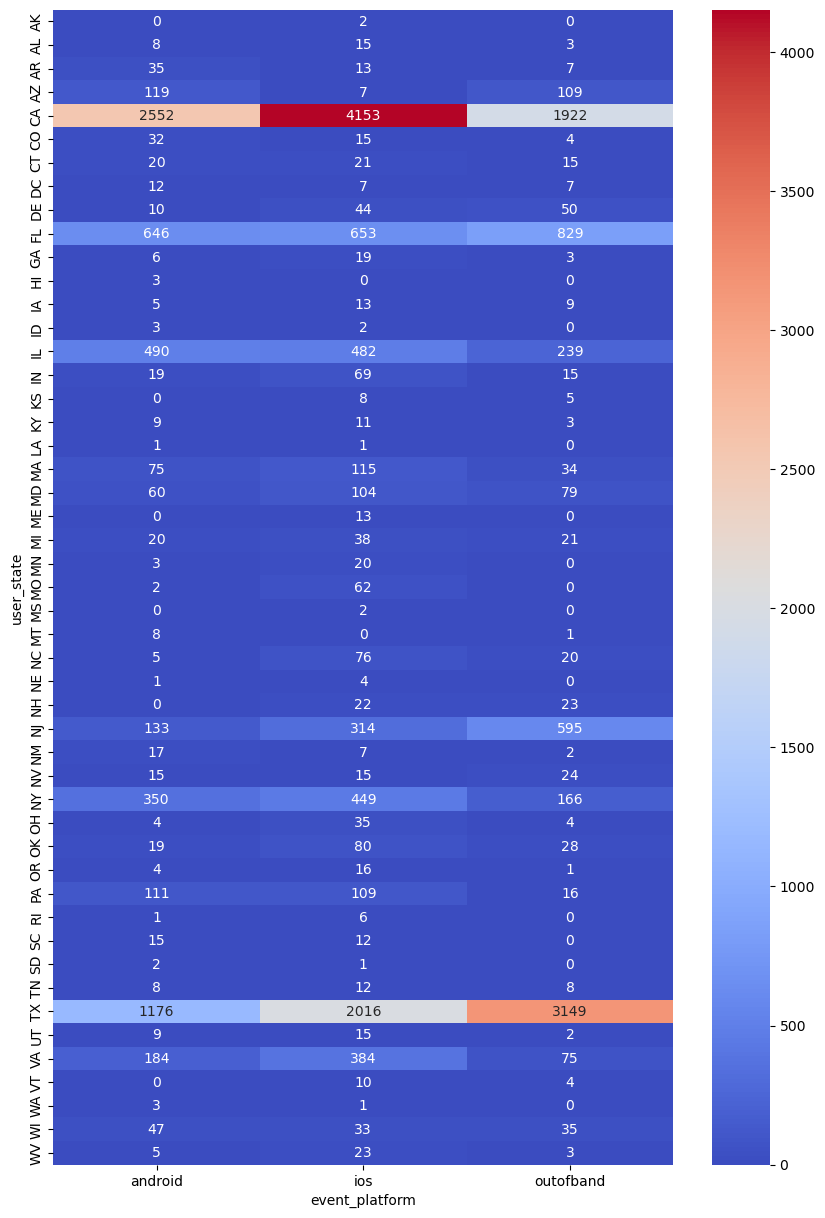

In [21]:
event_state_group = data[(data['user_state'].isnull() == False)].groupby(
    by=['user_state', 'event_platform']).size().unstack().fillna(0)
plt.figure(figsize=(10,15))
sns.heatmap(event_state_group, annot=True, fmt='g', cmap='coolwarm')

In [22]:
def fill_user_state(data):
    null_data = data[data['user_state'].isna()].copy()
    
    null_data['user_state'] = null_data.apply(lambda row: 'TX'
            if (row['event_platform'] == 'outofband')
            else 'CA', axis=1)
        
    data.update(null_data)
    
    return data

In [23]:
data = fill_user_state(data)

Now we need to classify the 'outofband' **event_platform** data

1. Firstly, as we did before with **device_manufacture** and **device_model**, we will fill missing values using information from same **userid**s
2. We'll use the mode to fill any gaps that remain. 

In [24]:
def fill_outofband(data):
    outofband_data = data[data['event_platform'] == 'outofband'].copy()
    
    outofband_data['event_platform'] = outofband_data.apply(
        lambda row: (data[(data['userid'] == row['userid']) &
                        (data['event_platform'] != 'outofband')]['event_platform'].mode())[0]
                if (data[(data['userid'] == row['userid']) &
                        (data['event_platform'] != 'outofband')].empty == False)
                else data['event_platform'].mode()[0], axis=1)
    
    data.update(outofband_data)
    return data

In [25]:
data = fill_outofband(data)

In [26]:
# percentage of missing data
data.isnull().sum() / data.shape[0]*100

userid                0.0
user_state            0.0
event_name            0.0
event_attributes      0.0
event_created_date    0.0
event_platform        0.0
device_manufacture    0.0
device_model          0.0
dtype: float64

Let's convert **event_created_date** from string to unix time format

In [27]:
data['event_created_date'] = data['event_created_date'].apply(lambda x: pd.to_datetime(x).value)

In [28]:
features = data.drop(['userid', 'event_name', 'event_attributes', 'event_created_date'], axis=1).columns

In [29]:
unique_users = data['userid'].unique()

In [30]:
user_properties = pd.DataFrame(index=unique_users, columns=features)     

In [31]:
for user in unique_users:
    user_data = data[data['userid'] == user]
    for feature in features:
        user_properties.loc[user][feature] = data[data['userid'] == user][feature].mode()[0]

In [32]:
user_properties

,user_state,event_platform,device_manufacture,device_model
c95c777785faec8dd910d019d7278ebe,CA,android,samsung,SM-N975U
f344be2d9a042b7444f3cc5279e38ef1,FL,android,samsung,SM-G973U1
e331ed81422d8fba55520a43a872e701,IL,ios,Apple,"iPhone12,1"
f6d930969a59cfb488ed4d126c7c856d,TX,android,samsung,SM-A716U
4ddc1ecfc4f1a31c22bb1346ae6c7c5b,TX,android,samsung,SM-A515F
...,...,...,...,...
6ebd67ba68c521c86d797a1c439d6de9,FL,android,samsung,SM-G998U1
833489856a3cc8840d47a2c1cadda36d,CA,android,vsmart,V350C
679eba26c4e75e0afb178360becfa21b,CA,android,Google,Pixel 3a
d46dcb2f00b6243de8714b979d524634,FL,ios,Apple,"iPhone13,4"


Now we will need to deal with **event_name** and **event_attributes**

In [33]:
data.sort_values(['userid', 'event_created_date'], inplace=True)
data.head(25)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
456,0006869712ec9841dc36234bce245203,MD,Add Payment Method Success,"{""Payment Method"":""Debit"",""Tokenized Pay"":""""}",1642618065000000000,android,samsung,SM-A716U
457,0006869712ec9841dc36234bce245203,MD,Subscription Premium,"{""Start Date"":""2022-01-19"",""Renewal Date"":""202...",1642618081000000000,android,samsung,SM-A716U
458,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""...",1642618088000000000,android,samsung,SM-A716U
459,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""...",1642618124000000000,android,samsung,SM-A716U
460,0006869712ec9841dc36234bce245203,MD,Add Vehicle Success,"{""Make"":""Chevrolet"",""Model"":""Express 3500"",""Co...",1642618234000000000,android,samsung,SM-A716U
5238,0006869712ec9841dc36234bce245203,MD,Subscription Premium Renew,"{""Start Date"":""2022-02-20"",""Renewal Date"":""202...",1645233136000000000,android,samsung,SM-A716U
2870,000a59897372c5e3c147b15685fefc65,CA,Sign Up Success,"{""Method"":""Apple""}",1644191488000000000,ios,Apple,"iPhone11,6"
2086,001244c572f1a681553bc045a378cacf,FL,Sign Up Success,"{""Method"":""Google""}",1643201345000000000,android,samsung,SM-G780G
4529,0032cb66b99f6baef57ec2aa04a9277f,CA,Sign Up Success,"{""Method"":""Apple""}",1644633125000000000,ios,Apple,"iPhone14,3"
12497,003f57fe2631ade57a86f6a2b96bb20c,CA,Sign Up Success,"{""Method"":""Apple""}",1647368642000000000,ios,Apple,"iPhone13,4"


In [34]:
unique_combinations = []

Get all the unique feature combinations

In [35]:
for user in unique_users:
    user_data = data[data['userid'] == user]
    for item in user_data.iloc:
        event = item['event_name']
        event_attributes = json.loads(item['event_attributes'])
        
        if len(event_attributes.keys()) > 0:
            for key in event_attributes.keys():
                if key not in ['Id', 'Amount', 'Start Date', 'Renewal Date', 'End Date']:
                    combination = event + ' ' + key + ' ' + event_attributes[key]
                elif key == 'Amount':
                    combination = event + ' ' + key
                unique_combinations.append(combination)
        else:
            unique_combinations.append(event)

In [36]:
unique_combinations = list(set(unique_combinations))
unique_combinations

['Account History Transaction Details Type Order',
 'Add Vehicle Success Model Cruze',
 'Add Vehicle Success Model Grand Caravan',
 'Add Vehicle Success Model CLA-Class',
 'Add Vehicle Success Model GLE-Class Coupe',
 'Add Vehicle Success Make tiffin',
 'Add Vehicle Success Model RDX',
 'Add Vehicle Success Model TL',
 'Add Vehicle Success Model Panamera',
 'Add Vehicle Success Model Aveo',
 'Add Vehicle Success Model Savana 2500',
 'Add Vehicle Success Rental state TX',
 'Add Vehicle Failed Error Message The operation couldn’t be completed. (Company.ErrorResponse error 0.)',
 'Add Payment Method Failed Error Message Postal code can only contain letters, numbers, spaces, and hyphens.',
 'Add Vehicle Success Make Chevrolet',
 'Add Vehicle Success Make Suzuki',
 'Add Vehicle Success Model Providence',
 'Add Vehicle Success Make Frieghtliner',
 'Chat Conversation Opened Transaction type ',
 'Add Vehicle Success Model LeSabre',
 'Add Vehicle Success Model Giulia',
 'Add Vehicle Success Mod

Dataframe for events

In [37]:
events_data = pd.DataFrame(index=unique_users, columns=unique_combinations)
events_data

,Account History Transaction Details Type Order,Add Vehicle Success Model Cruze,Add Vehicle Success Model Grand Caravan,Add Vehicle Success Model CLA-Class,Add Vehicle Success Model GLE-Class Coupe,Add Vehicle Success Make tiffin,Add Vehicle Success Model RDX,Add Vehicle Success Model TL,Add Vehicle Success Model Panamera,Add Vehicle Success Model Aveo,...,Account Setup Profile Skip Screen Address,Account Setup Profile Skip Screen Phone number,Transaction Refund Amount,Sign Up Error Method Email,Add Vehicle Success Model Titan XD,Add Vehicle Success Model 4-series,Add Vehicle Success Model Caliber,Add Vehicle Success Rental State DE,Add Vehicle Success Model CC,Add Vehicle Success Model Prius Hybrid
c95c777785faec8dd910d019d7278ebe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f344be2d9a042b7444f3cc5279e38ef1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e331ed81422d8fba55520a43a872e701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f6d930969a59cfb488ed4d126c7c856d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4ddc1ecfc4f1a31c22bb1346ae6c7c5b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6ebd67ba68c521c86d797a1c439d6de9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
833489856a3cc8840d47a2c1cadda36d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
679eba26c4e75e0afb178360becfa21b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d46dcb2f00b6243de8714b979d524634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Fill the events_data dataframe

In [38]:
for user in unique_users:
    user_data = data[data['userid'] == user]
    user_features = []
    for item in user_data.iloc:
        event = item['event_name']
        event_attributes = json.loads(item['event_attributes'])
        
        if len(event_attributes.keys()) > 0:
            for key in event_attributes.keys():
                if key not in ['Id', 'Amount', 'Start Date', 'Renewal Date', 'End Date']:
                    feature = event + ' ' + key + ' ' + event_attributes[key]
                    if feature not in user_features:
                        user_features.append(feature)
                        events_data.loc[user][feature] = 1
                    else:
                        events_data.loc[user][feature] += 1
                elif key == 'Amount':
                    feature = event + ' ' + key
                    if feature not in user_features:
                        user_features.append(feature)
                        events_data.loc[user][feature] = float(event_attributes[key])
                    else:
                        events_data.loc[user][feature] += float(event_attributes[key])
        else:
            if event not in user_features:
                user_features.append(event)
                events_data.loc[user][event] = 1
            else:
                events_data.loc[user][event] += 1

In [39]:
events_data = events_data.replace('', 0).fillna(0)

events_data['Transaction Refund Amount'].sum()

len(events_data.columns)

662

Merging dataframes with events features and user features

In [40]:
clean_data = pd.merge(events_data, user_properties, left_index=True, right_index=True)
clean_data

,Account History Transaction Details Type Order,Add Vehicle Success Model Cruze,Add Vehicle Success Model Grand Caravan,Add Vehicle Success Model CLA-Class,Add Vehicle Success Model GLE-Class Coupe,Add Vehicle Success Make tiffin,Add Vehicle Success Model RDX,Add Vehicle Success Model TL,Add Vehicle Success Model Panamera,Add Vehicle Success Model Aveo,...,Add Vehicle Success Model Titan XD,Add Vehicle Success Model 4-series,Add Vehicle Success Model Caliber,Add Vehicle Success Rental State DE,Add Vehicle Success Model CC,Add Vehicle Success Model Prius Hybrid,user_state,event_platform,device_manufacture,device_model
c95c777785faec8dd910d019d7278ebe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CA,android,samsung,SM-N975U
f344be2d9a042b7444f3cc5279e38ef1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,FL,android,samsung,SM-G973U1
e331ed81422d8fba55520a43a872e701,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,IL,ios,Apple,"iPhone12,1"
f6d930969a59cfb488ed4d126c7c856d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,TX,android,samsung,SM-A716U
4ddc1ecfc4f1a31c22bb1346ae6c7c5b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,TX,android,samsung,SM-A515F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6ebd67ba68c521c86d797a1c439d6de9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,FL,android,samsung,SM-G998U1
833489856a3cc8840d47a2c1cadda36d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CA,android,vsmart,V350C
679eba26c4e75e0afb178360becfa21b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CA,android,Google,Pixel 3a
d46dcb2f00b6243de8714b979d524634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,FL,ios,Apple,"iPhone13,4"


In [41]:
clean_data[clean_data['Subscription Premium Cancel'] > 1]

,Account History Transaction Details Type Order,Add Vehicle Success Model Cruze,Add Vehicle Success Model Grand Caravan,Add Vehicle Success Model CLA-Class,Add Vehicle Success Model GLE-Class Coupe,Add Vehicle Success Make tiffin,Add Vehicle Success Model RDX,Add Vehicle Success Model TL,Add Vehicle Success Model Panamera,Add Vehicle Success Model Aveo,...,Add Vehicle Success Model Titan XD,Add Vehicle Success Model 4-series,Add Vehicle Success Model Caliber,Add Vehicle Success Rental State DE,Add Vehicle Success Model CC,Add Vehicle Success Model Prius Hybrid,user_state,event_platform,device_manufacture,device_model
1e78610bb127137ae210339776ac17d2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CA,ios,Apple,"iPhone13,4"
b288242d86302c56eb49562a7d73a5f2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,IL,ios,Apple,"iPhone13,4"
73a754cf72593344bcd2412c1c24975b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CA,ios,Apple,"iPhone13,4"
5085db2422dd457f81d595b1adbfe4a8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,IL,android,motorola,moto g play (2021)
f57d02da24a18cd17a00aeddb46fa852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CA,ios,Apple,"iPhone10,5"
f510005f651751e9dd7fcf15fab240c3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CA,ios,Apple,"iPhone12,3"
c0b5d24cf149f2eca81332ead49a4108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CA,ios,Apple,"iPhone13,3"
270c14cfefa4e0dc596c90f6a8c6c363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,TX,ios,Apple,"iPhone13,3"
d263f69b765106b7790f098edb49f17b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,PA,ios,Apple,"iPhone12,5"
c952231e6ea12e2bdd6f735453422008,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CA,ios,Apple,"iPhone13,4"


Some users have canceled the subscription more than 1 time (2, to be precise). We will treat this as a binary classification problem, therefore we will fill this values with 1

In [42]:
clean_data['Subscription Premium Cancel'] = clean_data['Subscription Premium Cancel']\
.apply(lambda row: 1 if row > 0 else 0)

In [43]:
X = clean_data.drop(['Subscription Premium Cancel'], axis=1)
y = clean_data['Subscription Premium Cancel']
print(X.shape)
print(y.shape)

(3540, 665)
(3540,)


Applying one-hot encoding for categorical columns and scaling all the numerical values

In [44]:
categorical = [cname for cname in X.columns if X[cname].dtype == "object"]
numerical = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

numerical_transformer = Pipeline(steps=[('scaler',
                                         StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot',
                                           OneHotEncoder(drop='if_binary',
                                            handle_unknown='ignore',
                                            sparse=False))])

ct = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)],
        remainder='passthrough')

X = ct.fit_transform(X)
print(X.shape)

(3540, 1018)


Spliting data (we do not use the test set)

In [45]:
# train = 80%
# test = 20%

X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=69)

In [46]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Classifiers
classifiers = {
    "RandomForest" : RandomForestClassifier(random_state=0, class_weight='balanced'),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss', tree_method='hist'),
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False)
}

# Grids for grid search
RF_grid = {'n_estimators': [200, 250, 300, 500, 1000],
        'max_depth': [8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1]}

# Dictionary of all grids
grid = {
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid
}

C:\Users\Basenko_Nikita\anaconda\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [47]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(),
                           'ROC AUC score': np.zeros(len(classifiers)),
                           'Precision': np.zeros(len(classifiers)),
                           'Recall': np.zeros(len(classifiers)),
                           'F1-score': np.zeros(len(classifiers)), 
                           'PR-AUC': np.zeros(len(classifiers)), 
                           'Training time': np.zeros(len(classifiers))})

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    
    prediction = clf.predict(X_valid)
    valid_scores.iloc[i,1]=roc_auc_score(y_valid, prediction)
    valid_scores.iloc[i,2]=precision_score(y_valid, prediction)
    valid_scores.iloc[i,3]=recall_score(y_valid, prediction)
    valid_scores.iloc[i,4]=f1_score(y_valid, prediction)
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_valid, prediction)
    valid_scores.iloc[i,5]=auc(recall1, precision1)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,6]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,6])
    print('')
    i+=1

Model: RandomForest
Training time (mins): 2.16



C:\Users\Basenko_Nikita\anaconda\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Basenko_Nikita\anaconda\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model: XGBoost
Training time (mins): 0.9

Model: LGBM
Training time (mins): 0.2

Model: CatBoost
Training time (mins): 7.41



In [48]:
# Show results
valid_scores

,Classifer,ROC AUC score,Precision,Recall,F1-score,PR-AUC,Training time
0,RandomForest,0.899483,0.608696,0.84,0.705882,0.729998,2.16
1,XGBoost,0.812401,0.761905,0.64,0.695652,0.713664,0.90
2,LGBM,0.832401,0.772727,0.68,0.723404,0.737663,0.20
3,CatBoost,0.823161,0.785714,0.66,0.717391,0.734863,7.41


In [49]:
# Show best parameters from grid search
clf_best_params

{'RandomForest': {'max_depth': 12, 'n_estimators': 200},
 'XGBoost': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100},
 'LGBM': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100},
 'CatBoost': {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}}

In [53]:
# best parameters (tested multiple times)
model = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth=10, n_estimators=100)
model.fit(X_train, y_train)
prediction = model.predict(X_valid)

print('ROC AUC score:')
print(roc_auc_score(y_valid, prediction), "\n")
print('Precision:')
print(precision_score(y_valid, prediction), "\n")
print('Recall:')
print(recall_score(y_valid, prediction), "\n")
print('F1-score:')
print(f1_score(y_valid, prediction), "\n")

precision1, recall1, thresholds1 = precision_recall_curve(y_valid, prediction)
print('PR AUC score:')
print(auc(recall1, precision1), "\n") 

ROC AUC score:
0.9234042553191488 

Precision:
0.5625 

Recall:
0.9 

F1-score:
0.6923076923076923 

PR AUC score:
0.7347810734463277 



The best classifier is **RandomForest**, because we need to maximize **recall** (it is important to identify more positive cases, even if we mislabel some negative ones as positive: we don't want users to cancel the subscription). Also, it has a higher **ROC AUC score** and, moreover, a higher **precision-recall AUC** score (an important metric for us because we are more interested in **positive** cases).

In [50]:
{'RandomForest': {'max_depth': [10], 'n_estimators': [1000]},
 'XGBoost': {'learning_rate': [0.1], 'max_depth': [4], 'n_estimators': [100]},
 'LGBM': {'learning_rate': [0.1], 'max_depth': [4], 'n_estimators': [100]},
 'CatBoost': {'learning_rate': [0.1], 'max_depth': [12], 'n_estimators': [50]}}

{'RandomForest': {'max_depth': [10], 'n_estimators': [1000]},
 'XGBoost': {'learning_rate': [0.1], 'max_depth': [4], 'n_estimators': [100]},
 'LGBM': {'learning_rate': [0.1], 'max_depth': [4], 'n_estimators': [100]},
 'CatBoost': {'learning_rate': [0.1], 'max_depth': [12], 'n_estimators': [50]}}

In [62]:
for col, val in sorted(
                zip(clean_data.drop(['Subscription Premium Cancel'], axis=1).columns,model.feature_importances_),
                key=lambda x:x[1],
                reverse=True,)[:10]:
    print(f"{col:10} - {val:10.3f}")

Chat Conversation Started -      0.140
Subscription Premium Membership Type Monthly -      0.108
Wallet Opened -      0.088
Chat Conversation Opened From Menu -      0.067
Add Payment Method Success Promo code  -      0.053
Account History Transaction Details Type Auto Payment -      0.032
Add Payment Method Success Payment Method Debit -      0.032
Account History Transaction Details Type Pro Plan Subscription -      0.030
Transaction Refund Amount -      0.030
Order Premium Membership True -      0.024


Analyzing the feature_importances of our best model obtained with GridSearchCV, we can say the following:
- The users who interact with chat support (Metrics: Chat Conversation Started, Chat Conversation Opened From Menu) tend to unsubscribe the most.
- Those users who buy short-term subscriptions are more likely to cancel (this may be due to the fact that the user bought it to try).
- Promo code users are more likely to unsubscribe (most likely because the service was advertised to a non-loyal audience; the metrics Add Payment Method Success Promo code)
- Users who often look at their accounts (metrics: Account History Transaction Details Type Auto Payment, Account History Transaction Details Type Pro Plan Subscription) tend to unsubscribe as often as much as users of debit cards (Add Payment Method Success Payment Method Debit metrics).This is probably due to the difference between debit and credit cards. If the user does not have enough money in his account, he is likely to cancel the subscription.